<a href="https://colab.research.google.com/github/Thibisay/Proyecto-SIC-cubitUCV/blob/rama_gabo/Main2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/Thibisay/Proyecto-SIC-cubitUCV.git

fatal: destination path 'Proyecto-SIC-cubitUCV' already exists and is not an empty directory.


In [ ]:
#@title Importaciones
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import kagglehub, pandas as pd, os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#@title Si estas desde colab
path = kagglehub.dataset_download("svanoo/myanimelist-dataset")

#Seleccionando el archivo con los animes
anime_dataset = pd.read_csv(f"{path}/anime.csv", sep = '\t',on_bad_lines='skip')
anime_emotion = pd.read_csv("/content/Proyecto-SIC-cubitUCV/Analisis de datos/anime_emotion.csv")


In [ ]:
#@title importacion de archivos y formateo de columnas

anime_dataset.columns = anime_dataset.columns.str.lower()
anime_dataset.columns = anime_dataset.columns.str.replace(' ', '_')


In [ ]:
anime_dataset = anime_dataset[anime_dataset['anime_id'] != 44303] # anime que cumple con los 200 caracteres en synopsis pero no contiene datos utiles para su estudio
anime_dataset_filt = pd.DataFrame(anime_dataset[ anime_dataset["synopsis"].str.len() >= 200 ])
anime_dataset_filt = anime_dataset_filt.sort_values(by='popularity_rank')
anime_dataset_filt = anime_dataset_filt.dropna(subset=['score'])
anime_dataset_filt.index = range(0,len(anime_dataset_filt))

In [ ]:
#@title normalizacion de los generos
anime_dataset_filt['genres'] = anime_dataset_filt['genres'].apply(lambda x: x.split('|'))
data_generos = pd.DataFrame(list(set(elemento for sublista in anime_dataset_filt['genres'] for elemento in sublista)), columns=['genres_name'])
anime_genres_relation = anime_dataset_filt.explode('genres')[["anime_id", "genres"]] # expande anime_dataset_filt para dividir las listas en filas individuales

data_generos = anime_genres_relation.groupby('genres').size().reset_index(name='cantidad') # Agrupamos por el género y contamos la cantidad de animes en cada uno
data_generos.columns = ['genres_name', 'cantidad']

data_generos


,genres_name,cantidad
0,Action,2436
1,Adventure,1610
2,Avant Garde,95
3,Award Winning,3
4,Boys Love,109
5,Cars,48
6,Comedy,2860
7,Demons,317
8,Drama,1601
9,Ecchi,475


In [ ]:
#@title Eliminando columnas

col_delete_list = ["score_count","type", "status", "num_episodes", "start_date",
                   "end_date", "season", "studios", "clubs", "score_01_count",
                   "score_02_count", "score_03_count", "score_04_count", "score_05_count",
                   "score_06_count", "score_07_count", "score_08_count", "score_09_count",
                   "score_10_count", "num_episodes", "watching_count",
                   "completed_count","on_hold_count","dropped_count"]

filter_columns = list(filter(lambda x: True if x not in col_delete_list else False, list(anime_dataset_filt.columns)))

anime_dataset_filt = anime_dataset_filt[filter_columns]

anime_dataset_filt['longitud_synopsis_caracteres'] = anime_dataset_filt['synopsis'].apply(len)

In [ ]:
#@title Tabla de correlacion entre los generos y la popularidad


data_generos_promedio= pd.DataFrame(list(set(elemento for sublista in anime_dataset_filt['genres'] for elemento in sublista)), columns=['genres'])
df_exploded = anime_dataset_filt.explode('genres')


df_generos_count = df_exploded.groupby('genres').size().reset_index(name='cantidad_animes')
df_generos_count.columns = ['genres', 'cantidad_animes']

data_generos_promedio = pd.merge(data_generos_promedio, df_generos_count, on='genres', how='left')


promedio_ranking_por_genero = df_exploded.groupby('genres')['popularity_rank'].mean().reset_index()
promedio_ranking_por_genero.columns = ['genres', 'ranking_promedio']

data_generos_promedio = pd.merge(data_generos_promedio, promedio_ranking_por_genero, on='genres', how='left')


top_rango = 500

df_exploded['alto_rango'] = df_exploded['popularity_rank'] <= top_rango
proporcion_alto_rango = df_exploded.groupby('genres')['alto_rango'].mean().reset_index()
proporcion_alto_rango.columns = ['genres', 'proporcion_top_rango']

data_generos_promedio = pd.merge(data_generos_promedio, proporcion_alto_rango, on='genres', how='left')

animes_top_rango = df_exploded[df_exploded['popularity_rank'] <= top_rango]
frecuencia_top_genero = animes_top_rango['genres'].value_counts().reset_index()
frecuencia_top_genero.columns = ['genres', 'frecuencia_top_rango']

data_generos_promedio = pd.merge(data_generos_promedio, frecuencia_top_genero, on='genres', how='left')
data_generos_promedio = data_generos_promedio.fillna(0)

data_generos_promedio = data_generos_promedio.sort_values(by='ranking_promedio')
data_generos_promedio.index = range(0,len(data_generos_promedio))
data_generos_promedio


KeyError: 'genres'

In [ ]:
#@title Analisis de correlacion entre longitud de sinopsis y la puntuacion

correlacion_longSynop_populRank = anime_dataset_filt.select_dtypes(include=[float,int]).corr()

correlacion_longSynop_populRank


In [ ]:
#@title Analisis de correlacion entre longitud de sinopsis y la puntuacion
correlacion_longSynop_score = anime_dataset_filt[['longitud_synopsis_caracteres', 'score']].corr()


# plt.scatter(anime_dataset_filt['longitud_synopsis_caracteres'], anime_dataset_filt['score'], color='blue')
# plt.title('Relación entre Longitud de la Sinopsis y Rango de Popularidad')
# plt.xlabel('Longitud de la Sinopsis')
# plt.ylabel('La puntuación')
# plt.show()
anime_dataset_filt[['longitud_synopsis_caracteres', 'score']]
anime_dataset_filt.groupby('score').agg({'score':'count'})
correlacion_longSynop_score
# anime_dataset_filt[["genres", "anime_id"]]


,longitud_synopsis_caracteres,score
longitud_synopsis_caracteres,1.000000,0.302462
score,0.302462,1.000000


In [ ]:
#@title Otro modelo no ejecutar


# Cargar el modelo y el tokenizador T5 ajustado para emociones
modelo_id = "mrm8488/t5-base-finetuned-emotion"
tokenizer = AutoTokenizer.from_pretrained(modelo_id)
modelo = AutoModelForSeq2SeqLM.from_pretrained(modelo_id)

# Función para detectar la emoción principal en un texto dado
def detectar_emocion_t5(texto):
    # Preprocesar el texto para el modelo T5
    entradas = tokenizer("emotion: " + texto, return_tensors="pt", padding=True)

    # Generar la emoción usando el modelo
    salida = modelo.generate(**entradas)

    # Decodificar la emoción generada
    emocion = tokenizer.decode(salida[0], skip_special_tokens=True)
    return emocion


In [ ]:
#@title Clasificacion por emociones

anime_dataset_filt[["title", "synopsis"]].head()
synopsis = anime_dataset_filt["synopsis"].head()
emociones_animes = pd.read_csv('/content/Proyecto-SIC-cubitUCV/Analisis de datos/anime_emotion.csv')
i = 0
for element in anime_dataset_filt[["anime_id","title", "synopsis"]][len(emociones_animes):].itertuples():
  i += 1
  emociones_animes.loc[len(emociones_animes)] = [element.anime_id, detectar_emocion_t5(element.synopsis)]
  print(i)

  emociones_animes.to_csv("/content/Proyecto-SIC-cubitUCV/Analisis de datos/anime_emotion.csv", index=False)

In [ ]:


#@title Clasificacion por emociones

anime_dataset_filt[["title", "synopsis"]].head()
synopsis = anime_dataset_filt["synopsis"].head()
emociones_animes = pd.read_csv('/content/Proyecto-SIC-cubitUCV/Analisis de datos/anime_emotion.csv')
i = 0
for element in anime_dataset_filt[["anime_id","title", "synopsis"]][len(emociones_animes):].itertuples():
  i += 1
  emociones_animes.loc[len(emociones_animes)] = [element.anime_id, detectar_emocion_t5(element.synopsis)]
  print(i)

  emociones_animes.to_csv("/content/Proyecto-SIC-cubitUCV/Analisis de datos/anime_emotion.csv", index=False)



In [ ]:
#@title merge entre los animes y los generos


anime_dataset_filt
group_genres = list(anime_genres_relation.groupby("genres"))
merged_df = pd.merge(anime_dataset_filt, anime_genres_relation, on="anime_id", how="left")
merged_df = pd.merge(merged_df, anime_emotion, on="anime_id", how="left")
#merged_df.corr()
merged_df

,anime_id,anime_url,title,synopsis,main_pic,source_type,score,popularity_rank,members_count,favorites_count,plan_to_watch_count,total_count,pics,longitud_synopsis_caracteres,genres,emotion
0,16498,https://myanimelist.net/anime/16498/Shingeki_n...,Shingeki no Kyojin,"Centuries ago, mankind was slaughtered to near...",https://cdn.myanimelist.net/images/anime/10/47...,Manga,8.52,1,3329298,148196,152089,3329298,https://cdn.myanimelist.net/images/anime/5/445...,1133,Action,anger
1,16498,https://myanimelist.net/anime/16498/Shingeki_n...,Shingeki no Kyojin,"Centuries ago, mankind was slaughtered to near...",https://cdn.myanimelist.net/images/anime/10/47...,Manga,8.52,1,3329298,148196,152089,3329298,https://cdn.myanimelist.net/images/anime/5/445...,1133,Drama,anger
2,16498,https://myanimelist.net/anime/16498/Shingeki_n...,Shingeki no Kyojin,"Centuries ago, mankind was slaughtered to near...",https://cdn.myanimelist.net/images/anime/10/47...,Manga,8.52,1,3329298,148196,152089,3329298,https://cdn.myanimelist.net/images/anime/5/445...,1133,Fantasy,anger
3,16498,https://myanimelist.net/anime/16498/Shingeki_n...,Shingeki no Kyojin,"Centuries ago, mankind was slaughtered to near...",https://cdn.myanimelist.net/images/anime/10/47...,Manga,8.52,1,3329298,148196,152089,3329298,https://cdn.myanimelist.net/images/anime/5/445...,1133,Mystery,anger
4,16498,https://myanimelist.net/anime/16498/Shingeki_n...,Shingeki no Kyojin,"Centuries ago, mankind was slaughtered to near...",https://cdn.myanimelist.net/images/anime/10/47...,Manga,8.52,1,3329298,148196,152089,3329298,https://cdn.myanimelist.net/images/anime/5/445...,1133,Military,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26346,40361,https://myanimelist.net/anime/40361/Shiro_no_K...,"Shiro no Kanga""roo"" no Uta",A musical web short by Asami Ike made in honor...,https://cdn.myanimelist.net/images/anime/1373/...,Original,3.46,16179,222,0,34,223,https://cdn.myanimelist.net/images/anime/1373/...,281,Music,joy
26347,40361,https://myanimelist.net/anime/40361/Shiro_no_K...,"Shiro no Kanga""roo"" no Uta",A musical web short by Asami Ike made in honor...,https://cdn.myanimelist.net/images/anime/1373/...,Original,3.46,16179,222,0,34,223,https://cdn.myanimelist.net/images/anime/1373/...,281,Kids,joy
26348,39704,https://myanimelist.net/anime/39704/Shiroi_Una...,Shiroi Unabara,Satomi Maiya's graduate work at the Tokyo Univ...,https://cdn.myanimelist.net/images/anime/1536/...,Original,5.92,16308,214,0,45,214,https://cdn.myanimelist.net/images/anime/1536/...,293,Drama,fear
26349,50110,https://myanimelist.net/anime/50110/Kata_no_Ato,Kata no Ato,My friend Emi appeared in my dream. I was so s...,https://cdn.myanimelist.net/images/anime/1694/...,Original,5.58,16371,210,1,61,210,https://cdn.myanimelist.net/images/anime/1694/...,326,Girls Love,surprise


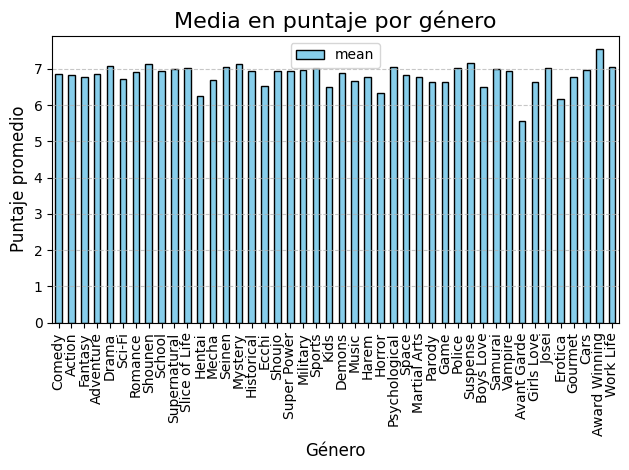

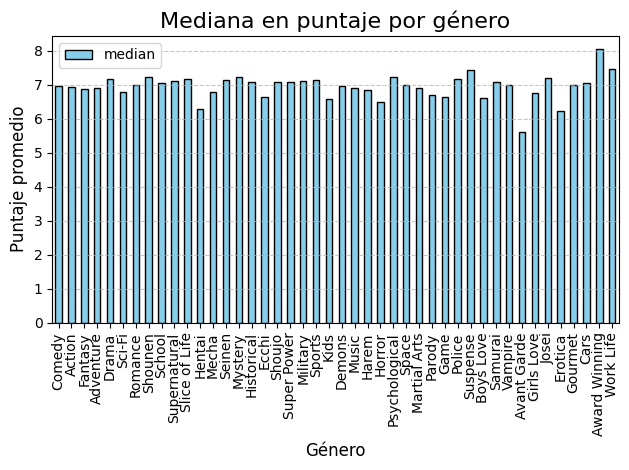

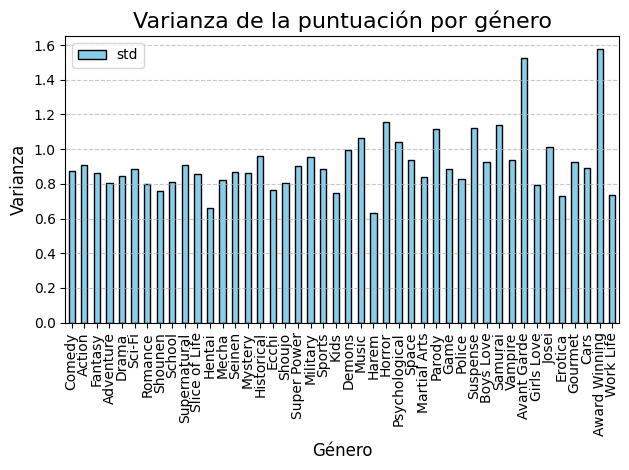

In [ ]:
#@title Grafico de score promedio por genero
# Grafico de la media
df = merged_df.groupby("genres")["score"].agg(['mean','median','std', 'count']).sort_values(by="count", ascending=False)
df[['mean']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Media en puntaje por género", fontsize=16)
plt.xlabel("Género", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()  # Ajustar para evitar recortes
plt.show()

# Grafico de la mediana
df[['median']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Mediana en puntaje por género", fontsize=16)
plt.xlabel("Género", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Ajustar para evitar recortes
plt.show()

# Grafico de la mediana
df[['std']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Varianza de la puntuación por género", fontsize=16)
plt.xlabel("Género", fontsize=12)
plt.ylabel("Varianza", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Ajustar para evitar recortes
plt.show()

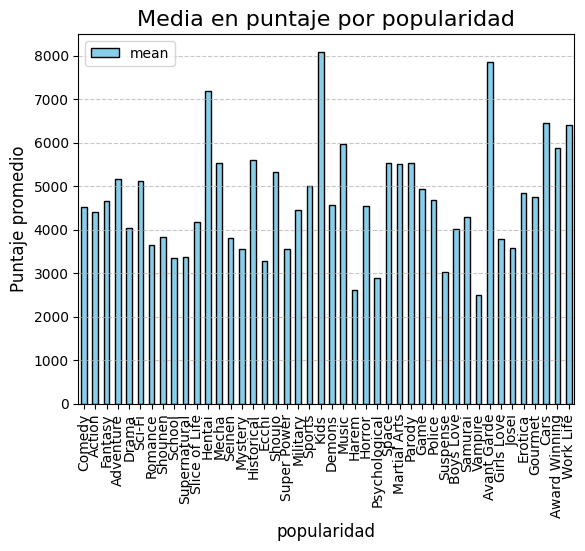

In [ ]:
#@title media popularidad

# Grafico de la media
df = merged_df.groupby("genres")["popularity_rank"].agg(['mean','median','std', 'count']).sort_values(by="count", ascending=False)
df[['mean']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Media en puntaje por popularidad", fontsize=16)
plt.xlabel("popularidad", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)


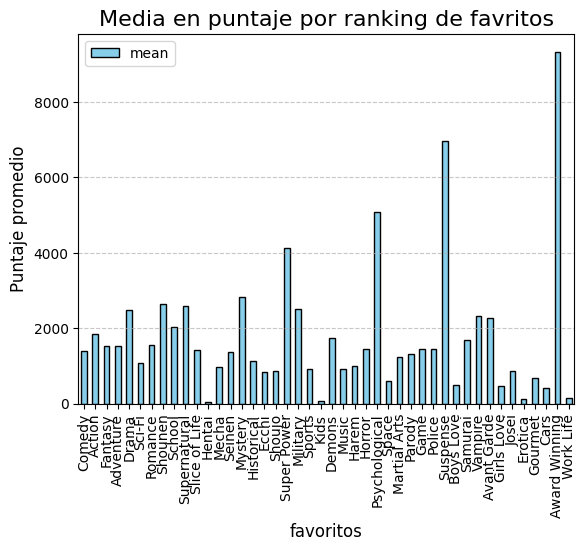

In [ ]:
#@title fav

# Grafico de la media
df = merged_df.groupby("genres")["favorites_count"].agg(['mean','median','std', 'count']).sort_values(by="count", ascending=False)
df[['mean']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Media en puntaje por ranking de favoritos", fontsize=16)
plt.xlabel("favoritos", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)


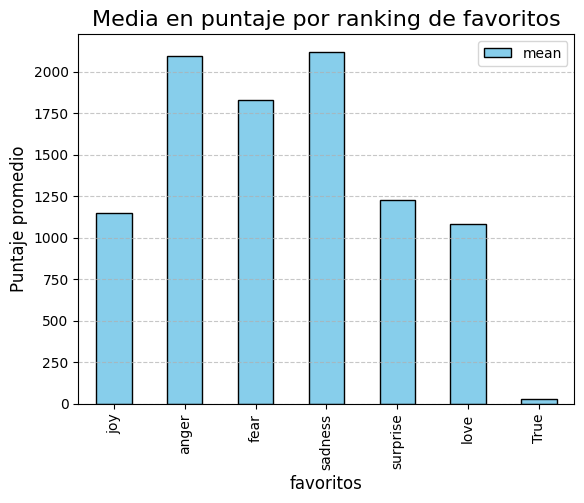

In [ ]:
#@title emociones - fav


# Grafico de la media
df = merged_df.groupby("emotion")["favorites_count"].agg(['mean','median','std', 'count']).sort_values(by="count", ascending=False)
df[['mean']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Media en puntaje por ranking de favoritos", fontsize=16)
plt.xlabel("favoritos", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)


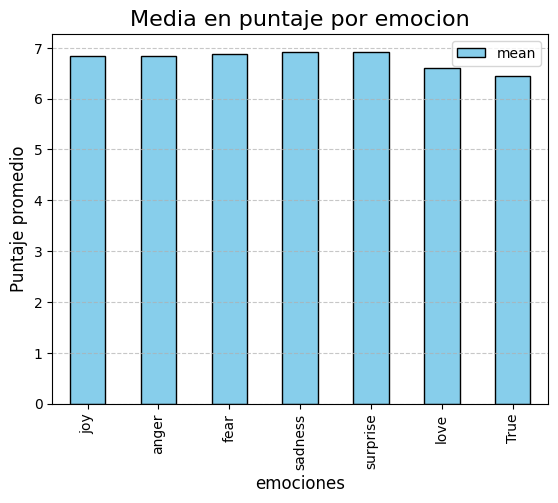

In [ ]:
#@title emociones - score

# Grafico de la media
df = merged_df.groupby("emotion")["score"].agg(['mean','median','std', 'count']).sort_values(by="count", ascending=False)
df[['mean']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Media en puntaje por emocion", fontsize=16)
plt.xlabel("emociones", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

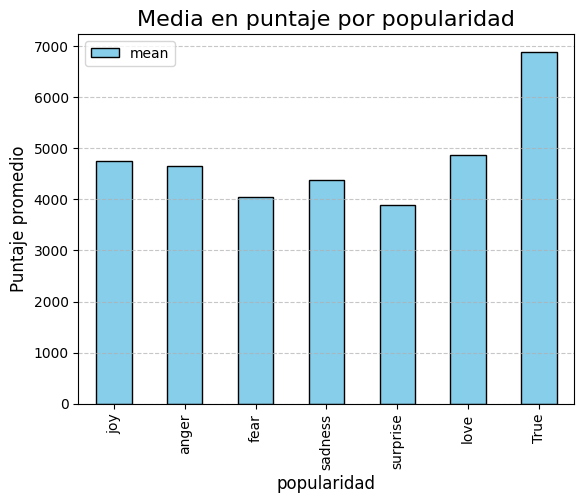

In [ ]:
#@title emociones - popularidad

# Grafico de la media
df = merged_df.groupby("emotion")["popularity_rank"].agg(['mean','median','std', 'count']).sort_values(by="count", ascending=False)
df[['mean']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Media en puntaje por popularidad", fontsize=16)
plt.xlabel("popularidad", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

In [ ]:
#@title Correlación entre los géneros y el score
import seaborn as sns

df_encoded = pd.get_dummies(merged_df[['score','genres']], columns=['genres'])
genre_score_corr = df_encoded.corr()['score'].drop('score')
genre_score_corr.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Correlación entre géneros y puntaje')
plt.xlabel('Género')
plt.ylabel('Correlación')
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de calor de correlaciones')
plt.show()


In [ ]:
#@title Frecuencia de popularidad en los géneros
import seaborn as sns

genre_dummies = pd.get_dummies(merged_df[['popularity_rank','genres']], columns=['genres'])
genre_frequency = genre_dummies.sum()
anime_with_genres = pd.concat([merged_df, genre_dummies], axis=1)
genre_scores = anime_with_genres.drop(columns=['genres']).groupby(genre_dummies.columns, axis=1).mean().mean()
genre_scores


In [ ]:
#@title Grafico de score promedio por genero
# Grafico de la media
df = merged_df.groupby("genres")["score"].agg(['mean','median','std', 'count']).sort_values(by="count", ascending=False)
df[['mean']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Media en puntaje por género", fontsize=16)
plt.xlabel("Género", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()  # Ajustar para evitar recortes
plt.show()

# Grafico de la mediana
df[['median']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Mediana en puntaje por género", fontsize=16)
plt.xlabel("Género", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Ajustar para evitar recortes
plt.show()

# Grafico de la mediana
df[['std']].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Varianza de la puntuación por género", fontsize=16)
plt.xlabel("Género", fontsize=12)
plt.ylabel("Varianza", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Ajustar para evitar recortes
plt.show()


In [ ]:
#@title Grafico de score promedio por genero
# Grafico de la media
df = merged_df.groupby("emotion")["score"].agg(['mean','median','std', 'count']).sort_values(by="count", ascending=False)
df[['mean']].plot(kind="bar", color="skyblue", edgecolor="black", legend=False)
plt.title("Media en puntaje por emoción", fontsize=16)
plt.xlabel("Emoción", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()  # Ajustar para evitar recortes
plt.show()

# Grafico de la mediana
df[['median']].plot(kind="bar", color="skyblue", edgecolor="black", legend=False)
plt.title("Mediana en puntaje por emoción", fontsize=16)
plt.xlabel("Emoción", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Ajustar para evitar recortes
plt.show()

# Grafico de la mediana
df[['std']].plot(kind="bar", color="skyblue", edgecolor="black", legend=False)
plt.title("Varianza de la puntuación por emoción", fontsize=16)
plt.xlabel("Emoción", fontsize=12)
plt.ylabel("Varianza", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Ajustar para evitar recortes
plt.show()


In [ ]:


#@title Correlación entre los géneros y el score
import seaborn as sns

df_encoded = pd.get_dummies(merged_df[['score','emotion']], columns=['emotion'])
genre_score_corr = df_encoded.corr()['score'].drop('score')
genre_score_corr.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Correlación entre emociones y puntaje')
plt.xlabel('Emoción')
plt.ylabel('Correlación')
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de calor de correlaciones')
plt.show()


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
emociones_animes.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.ylabel('Emociones')
plt.xlabel('Cantidad')
plt.title('Cantidad de animes por emoción')
plt.show()


In [ ]:
anime_dataset_filt['popularidad_categoria'] = pd.cut(anime_dataset_filt['popularity_rank'],bins=[0, 2000, 4000, 6000, 8000, anime_dataset_filt['popularity_rank'].max()],labels=['Muy Popular', 'Popular', 'Moderado', 'Bajo', 'Muy Bajo'])


# Función para obtener emociones para cada anime usando id_anime
def obtener_emociones(id_anime):
    # Filtramos emociones_animes para obtener las emociones asociadas a un id_anime
    emociones = emociones_animes[emociones_animes['anime_id'] == id_anime]['emotion'].tolist()
    return emociones

# Crear una lista para almacenar los resultados
emociones_popularidad = []

# Recorrer cada anime en anime_dataset_filt
for _, anime in anime_dataset_filt.iterrows():
    # Obtener las emociones del anime
    emociones = obtener_emociones(anime['anime_id'])
    # Obtener la categoría de popularidad
    categoria_popularidad = anime['popularidad_categoria']

    # Guardar las emociones junto con la categoría de popularidad
    for emocion in emociones:
        emociones_popularidad.append([categoria_popularidad, emocion])

# Convertir los resultados a un DataFrame
df_emociones_popularidad = pd.DataFrame(emociones_popularidad, columns=['popularidad_categoria', 'emociones'])

# Contar las emociones por popularidad
emotion_counts = df_emociones_popularidad.groupby(['popularidad_categoria', 'emociones']).size().unstack(fill_value=0)
categorias_ordenadas = ['Muy Popular', 'Popular', 'Moderado', 'Bajo', 'Muy Bajo']
emotion_counts.index = pd.CategoricalIndex(emotion_counts.index, categories=categorias_ordenadas, ordered=True)

emotion_counts = emotion_counts.sort_index()
emotion_counts


In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

# Crear un gráfico para cada categoría
for i, categoria in enumerate(emotion_counts.index):
    ax = axes[i]
    datos_categoria = emotion_counts.loc[categoria]
    emotion_counts.loc[categoria].plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Popularidad: {categoria}')
    axes[i].set_xlabel('Emociones')
    axes[i].set_ylabel('Cantidad de Animes')
    axes[i].tick_params(axis='x', rotation=45)

    # Agregar los valores encima de las barras
    for j, valor in enumerate(datos_categoria):
        ax.text(j, valor + 0.5, str(valor), ha='center', va='bottom', fontsize=10)

# Agregar la leyenda para los rangos de puntuación
fig.text(0.5, 1.02, "Cantidad De animes por Categorías de Popularidad y Emociones", ha='center', va='center', fontsize=20)

rango_puntuaciones = [
    "Muy Popular: 1 - 2000 Rango",
    "Popular: 2001 - 4000 Rango",
    "Moderado: 4001 - 6000 Rango",
    "Bajo: 6001 - 8000 Rango",
    "Muy Bajo: 8001 - 10000 Rango"
]
fig.legend(
    rango_puntuaciones,
    loc="upper center",
    ncol=5,
    bbox_to_anchor=(0.5, 1.15),
    fontsize='medium',
    frameon=False
)

# Ajustar el diseño
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reservar espacio superior para la leyenda
plt.show()


In [ ]:
# Visualización: Gráfico de barras apiladas
emotion_counts.sum(axis=1).plot(kind='bar', figsize=(10, 8), color = 'skyblue' )
plt.title('Cantidad de animes por categoría de Popularidad')
plt.xlabel('Categoría de popularidad')
plt.ylabel('Cantidad de animes')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Crear las categorías de score en anime_dataset_filt
anime_dataset_filt['score_categoria'] = pd.cut(anime_dataset_filt['score'],
                                               bins=[0, 3, 5, 7, 8, 10],
                                               labels=['Bajo', 'Medio Bajo', 'Medio Alto', 'Alto', 'Excelente'])

# Función para obtener emociones para cada anime usando id_anime
def obtener_emociones(id_anime):
    # Filtramos emociones_animes para obtener las emociones asociadas a un id_anime
    emociones = emociones_animes[emociones_animes['anime_id'] == id_anime]['emotion'].tolist()
    return emociones

# Crear una lista para almacenar los resultados
emociones_score = []

# Recorrer cada anime en anime_dataset_filt
for _, anime in anime_dataset_filt.iterrows():
    # Obtener las emociones del anime
    emociones = obtener_emociones(anime['anime_id'])
    # Obtener la categoría de score
    categoria_score = anime['score_categoria']

    # Guardar las emociones junto con la categoría de score
    for emocion in emociones:
        emociones_score.append([categoria_score, emocion])

# Convertir los resultados a un DataFrame
df_emociones_score = pd.DataFrame(emociones_score, columns=['score_categoria', 'emociones'])

# Contar las emociones por score
emotion_counts_score = df_emociones_score.groupby(['score_categoria', 'emociones']).size().unstack(fill_value=0)

# Asegurar que los índices de score estén en el orden correcto
# Especificar el orden de las categorías de score
categorias_score_ordenadas = ['Bajo', 'Medio Bajo', 'Medio Alto', 'Alto', 'Excelente']
emotion_counts_score.index = pd.CategoricalIndex(emotion_counts_score.index, categories=categorias_score_ordenadas, ordered=True)

# Reorganizar el DataFrame para asegurar que el índice de score esté en el orden correcto
emotion_counts_score = emotion_counts_score.sort_index()
emotion_counts_score


In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

# Crear un gráfico para cada categoría
for i, categoria in enumerate(emotion_counts_score.index):
    ax = axes[i]
    datos_categoria = emotion_counts_score.loc[categoria]

    # Crear el gráfico de barras
    datos_categoria.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

    # Títulos y etiquetas
    ax.set_title(f'Categoría: {categoria}')
    ax.set_xlabel('Emociones')
    ax.set_ylabel('Cantidad de Animes')
    ax.tick_params(axis='x', rotation=45)

    # Agregar los valores encima de las barras
    for j, valor in enumerate(datos_categoria):
        ax.text(j, valor + 0.5, str(valor), ha='center', va='bottom', fontsize=10)


# Agregar la leyenda para los rangos de puntuación
fig.text(0.5, 1.02, "Animes por Categorías de Puntuación y Emociones", ha='center', va='center', fontsize=20)

rango_puntuaciones = [
    "Bajo: 0 - 2 puntos",
    "Medio Bajo: 3 - 4 puntos",
    "Medio Alto: 5 - 6 puntos",
    "Alto: 7 - 8 puntos",
    "Excelente: 9 - 10 puntos"
]
fig.legend(

    rango_puntuaciones,
    loc="upper center",
    ncol=5,
    bbox_to_anchor=(0.5, 1.15),
    fontsize='medium',
    frameon=False
)

# Ajustar el diseño
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reservar espacio superior para la leyenda
plt.show()


In [ ]:
# Crear el gráfico de barras simple
ax = emotion_counts_score.sum(axis=1).plot(kind='bar', color='skyblue',figsize=(10, 6))

# Establecer el título y las etiquetas
plt.title('Cantidad de animes por categoría de Puntos')
plt.xlabel('Categoría de Puntos')
plt.ylabel('Cantidad de Animes')

# Rotar las etiquetas del eje X
plt.xticks(rotation=45)

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()